# Credit Card Default Prediction - Machine Learning

### Introduction

The requisite data has been pulled and wrangled in the macro_capstone_data_wrangling notebook and explored in the macro_capstone_data_exploration notebook. Now, the data needs to be evaluated using a Machine Learning model to determine whether and how accurately it can be used to predict the aggregate credit card default rate.

First, the setup will be performed - all libraries and requisite data sources will be imported. Next, an XGBoost Regressor will be used to predict the default rate's values. Finally, the output will be explored.

First, the requisite libraries are imported.

In [1]:
import numpy as np
import pandas as pd
import fredapi
import datetime as dt
import calendar
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Next, the independent and dependent datasets that were created using the Data Wrangling notebook are imported as dataframes.

In [2]:
ind_df = pd.read_pickle(r'data\ind_df.pkl')
dep_df = pd.read_pickle(r'data\dep_df.pkl')

Infinite values are sometimes created during feature engineering, as a percent change over time can sometimes be infinite. For this reason, infinite values are replaced with NaN values.

In [3]:
ind_df = ind_df.replace([np.inf, -np.inf], np.nan)
ind_df = ind_df.dropna(axis=1)

Next, the Machine Learning step is performed. The steps in this process are:
<ol>
    <li>Lag the dependent variable by one month. This means that each month will be predicting the <i>next month's</i> value.</li>
    <li>Instantiate an XG Boost regressor instance and set up a hyperparameter grid for tuning.</li>
    <li>Run the model, finding the hyperparameters of best fit and the prediction that it yields</li>
    <li>Loop through steps (1) through (3) - using the hyperparameters found in (3), perform the same XGBoost prediction of the 2nd to most recent month, 3rd to most recent month, etc. for the prior 12 years</li>
    </ol>
    
For each iteration, the value is recorded so that the RMSE can later be calculated.

In [4]:
result_dict = {}
#for i in range(1, 145):

# Lag the dependent df by one month so that the value being predicted is the folowing month.
modified_dep_df = dep_df.shift(-1).iloc[:-1]
# Remove the latest row of the data, for which there is now no dependent variable
modified_ind_df = ind_df.iloc[:-1]

for i in range(1, 144):
    Xtrain = np.nan_to_num(modified_ind_df.iloc[:-i].values)
    ytrain = np.nan_to_num(modified_dep_df.iloc[:-i].values)
    Xtest = np.nan_to_num(modified_ind_df.iloc[-i].values).reshape(1, -1)
    ytest = np.nan_to_num(modified_dep_df.iloc[-i])
    if i == 1:
        print('Stating hyperparameter tuning...')
        xgb1 = xgb.XGBRegressor()
        parameters = {'nthread':[4],
                      'objective':['reg:squarederror'],
                      'learning_rate': [.02, .03, 0.05, .07], #so called `eta` value
                      'max_depth': [5, 6, 7],
                      'min_child_weight': [4],
                      'silent': [1],
                      'subsample': [0.7],
                      'colsample_bytree': [0.7],
                      'n_estimators': [400, 500, 600, 700, 800]}

        xgb_grid = GridSearchCV(xgb1,
                                parameters,
                                cv = 2,
                                n_jobs = 5,
                                verbose=True)

        xgb_grid.fit(Xtrain, ytrain)

        best_params = xgb_grid.best_params_
    print('Starting XGB...')
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', params=best_params)
    xg_reg.fit(Xtrain, ytrain)

    y_test_xgb = xg_reg.predict(Xtest)
    result_dict[i] = y_test_xgb
    
    # Create a dataframe containing feature importances for the iteration
    temp = {'feature':ind_df.columns, f'value{i}':xg_reg.feature_importances_}
    field_df = pd.DataFrame(temp).set_index('feature')
    
    # If this is the first iteration, create a dataframe containing feature importance for the iteration. Otherwise,
    # append this iteration's feature importance to the existing dataframe.
    try:
        feat_imp_df_1m = feat_imp_df.merge(right=field_df, left_index=True, right_index=True)
    except NameError:
        feat_imp_df_1m = field_df
    
    print(f'predicted: {y_test_xgb}\nactual:{ytest}')

Stating hyperparameter tuning...
Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 10.2min
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed: 24.9min finished


Starting XGB...
predicted: [2.4671583]
actual:[2.42]
Starting XGB...
predicted: [2.4830675]
actual:[2.42]
Starting XGB...
predicted: [2.5508444]
actual:[2.42]
Starting XGB...
predicted: [2.5916367]
actual:[2.49210386]
Starting XGB...
predicted: [2.5323954]
actual:[2.55079891]
Starting XGB...
predicted: [2.55499]
actual:[2.59]
Starting XGB...
predicted: [2.5774863]
actual:[2.61810737]
Starting XGB...
predicted: [2.5181973]
actual:[2.63056805]
Starting XGB...
predicted: [2.5276206]
actual:[2.63]
Starting XGB...
predicted: [2.4976196]
actual:[2.61673872]
Starting XGB...
predicted: [2.4588594]
actual:[2.59025426]
Starting XGB...
predicted: [2.4574695]
actual:[2.54]
Starting XGB...
predicted: [2.4814062]
actual:[2.46502839]
Starting XGB...
predicted: [2.4307275]
actual:[2.38007064]
Starting XGB...
predicted: [2.4706907]
actual:[2.35]
Starting XGB...
predicted: [2.543638]
actual:[2.38788615]
Starting XGB...
predicted: [2.5280757]
actual:[2.48049831]
Starting XGB...
predicted: [2.5370343]
act

Next, the exact process described above is repeated, except that step (1) is to lag the data by <i>six</i> months. This means that the model is predicting what the default rate will be six months in the future. If the results are accurate, this would be significantly more valuable than the one-month lagged rate, as changes taking place further in the future are easier to action on and less likely to be predicted by other means.

In [15]:
result_dict_6m = {}
#for i in range(1, 145):

# Lag the dependent df by one month so that the value being predicted is the folowing month.
modified_dep_df = dep_df.shift(-6).iloc[:-6]
# Remove the latest row of the data, for which there is now no dependent variable
modified_ind_df = ind_df.iloc[:-6]

for i in range(1, 144):
    Xtrain = np.nan_to_num(modified_ind_df.iloc[:-i].values)
    ytrain = np.nan_to_num(modified_dep_df.iloc[:-i].values)
    Xtest = np.nan_to_num(modified_ind_df.iloc[-i].values).reshape(1, -1)
    ytest = np.nan_to_num(modified_dep_df.iloc[-i])
    if i == 1:
        print('Stating hyperparameter tuning...')
        xgb1 = xgb.XGBRegressor()
        parameters = {'nthread':[4],
                      'objective':['reg:squarederror'],
                      'learning_rate': [.02, .03, 0.05, .07], #so called `eta` value
                      'max_depth': [5, 6, 7],
                      'min_child_weight': [4],
                      'silent': [1],
                      'subsample': [0.7],
                      'colsample_bytree': [0.7],
                      'n_estimators': [400, 500, 600, 700, 800]}

        xgb_grid = GridSearchCV(xgb1,
                                parameters,
                                cv = 2,
                                n_jobs = 5,
                                verbose=True)

        xgb_grid.fit(Xtrain, ytrain)

        best_params = xgb_grid.best_params_
    print('Starting XGB...')
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', params=best_params)
    xg_reg.fit(Xtrain, ytrain)

    y_test_xgb = xg_reg.predict(Xtest)
    result_dict_6m[i] = y_test_xgb
    
    # Create a dataframe containing feature importances for the iteration
    temp = {'feature':ind_df.columns, f'value{i}':xg_reg.feature_importances_}
    field_df = pd.DataFrame(temp).set_index('feature')
    
    # If this is the first iteration, create a dataframe containing feature importance for the iteration. Otherwise,
    # append this iteration's feature importance to the existing dataframe.
    try:
        feat_imp_df_6m = feat_imp_df_6m.merge(right=field_df, left_index=True, right_index=True)
    except NameError:
        feat_imp_df_6m = field_df
    
    print(f'predicted: {y_test_xgb}\nactual:{ytest}')

Stating hyperparameter tuning...
Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed: 24.2min finished
C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Starting XGB...
predicted: [2.4028578]
actual:[2.42]
Starting XGB...
predicted: [2.4414668]
actual:[2.42]
Starting XGB...
predicted: [2.530955]
actual:[2.42]
Starting XGB...
predicted: [2.540182]
actual:[2.49210386]
Starting XGB...
predicted: [2.593598]
actual:[2.55079891]
Starting XGB...
predicted: [2.6260393]
actual:[2.59]
Starting XGB...
predicted: [2.6266356]
actual:[2.61810737]
Starting XGB...
predicted: [2.59221]
actual:[2.63056805]
Starting XGB...
predicted: [2.6090176]
actual:[2.63]
Starting XGB...
predicted: [2.5258188]
actual:[2.61673872]
Starting XGB...
predicted: [2.5496318]
actual:[2.59025426]
Starting XGB...
predicted: [2.4899971]
actual:[2.54]
Starting XGB...
predicted: [2.431737]
actual:[2.46502839]
Starting XGB...
predicted: [2.4286826]
actual:[2.38007064]
Starting XGB...
predicted: [2.5188065]
actual:[2.35]
Starting XGB...
predicted: [2.5508804]
actual:[2.38788615]
Starting XGB...
predicted: [2.5354908]
actual:[2.48049831]
Starting XGB...
predicted: [2.5118735]
actual

The squared error is calculated for both of the two run-throughs.

In [7]:
squared_error = []
for k, v in result_dict.items():
    squared_error.append((v[0] - dep_df.values[-k])**2)
    
squared_error_6m = []
for k, v in result_dict_6m.items():
    squared_error_6m.append((v[0] - dep_df.values[-k])**2)

Next, the RMSE is calculated by summing the squared errors and taking the square root of the result. The results are quite good - RMSEs slightly below 0.3 mean that there is a fairly high level of precision in predicting the credit card default rate.

Surprisingly, the RMSE for a one-month lag is <i>higher</i> than that for a six-month lag - one would expect nearer-term values to be easier to predict, which is not the case for this model.

In [8]:
print(f'root mean squared error for one-month lag:\n{np.mean(squared_error)**.5}')
print(f'root mean squared error for six-month lag:\n{np.mean(squared_error_6m)**.5}')

root mean squared error for one-month lag:
0.2978164213329717
root mean squared error for six-month lag:
0.2841115738506383


The series shown below contains the average feature importance for each of the 144 iterations performed above on the six-month-lagged data. Only the 20 most important features are shown.

There are not significant surprises in the feaures shown - they are either known economic indicators or very sensible items to predict the loan default rate.

In [25]:
(feat_imp_df_6m.sum(axis=1)/144).sort_values(ascending=False).head(20)

feature
GDP_interp_linear_GDP          0.078156
HTRUCKSSAAR_12mth_per_ch       0.073253
GDPC1_9mth_val_ch              0.062874
CPIAUCSL_value                 0.054636
TDSP_value                     0.045195
MSPUS_12mth_per_ch             0.041364
T10Y2Y_365day_val_ch_median    0.035186
HTRUCKSSAAR_12mth_val_ch       0.025162
CP_12mth_per_ch                0.024532
GDPC1_12mth_val_ch             0.023567
VIXCLS_value_min               0.022132
VIXCLS_value_mean              0.021893
UNEMPLOY_9mth_per_ch           0.019394
FEDFUNDS_9mth_val_ch           0.019266
CSUSHPINSA_12mth_val_ch        0.018480
CSCICP03USM665S_value          0.017512
GDP_value                      0.016930
TCU_12mth_val_ch               0.016733
HOUST_value                    0.015369
LNS14000024_6mth_per_ch        0.015116
dtype: float32

Next, a dataframe is created to contain the date of each observation, the observation, and the six-month lagged predicted value.

In [9]:
pred_df = pd.DataFrame(columns=['actual', 'predicted'])

In [10]:
for i in range(1, 144):
    d = modified_dep_df.index[-i]
    pred_df.loc[d, 'actual'] = modified_dep_df.values[-i][0]
    pred_df.loc[d, 'predicted'] = result_dict_6m[i][0]

The actual and predicted values are plotted on the same graph.

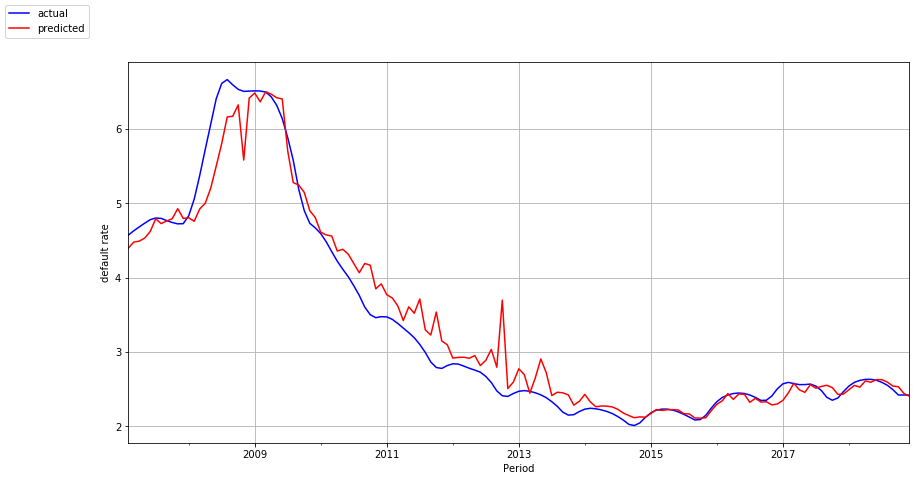

In [28]:
ind_series = pred_df.loc[:, 'actual']
ind_name = 'actual'

dep_series = pred_df.loc[:, 'predicted']
dep_name = 'predicted'

fig = plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label=ind_name)
ax1.set_ylabel('default rate')
ax2 = dep_series.plot(color='red', grid=True, label=dep_name)
_ = fig.legend(loc='upper left')

With the exception of a few unexpected variances, the predicted values are quite close to the actual values. The beginning of the Great Recession, roughly December 2007 through December 2008, is a time when being able to predict a rise in the default rate would have been more useful. For that reason, the period is graphed below.

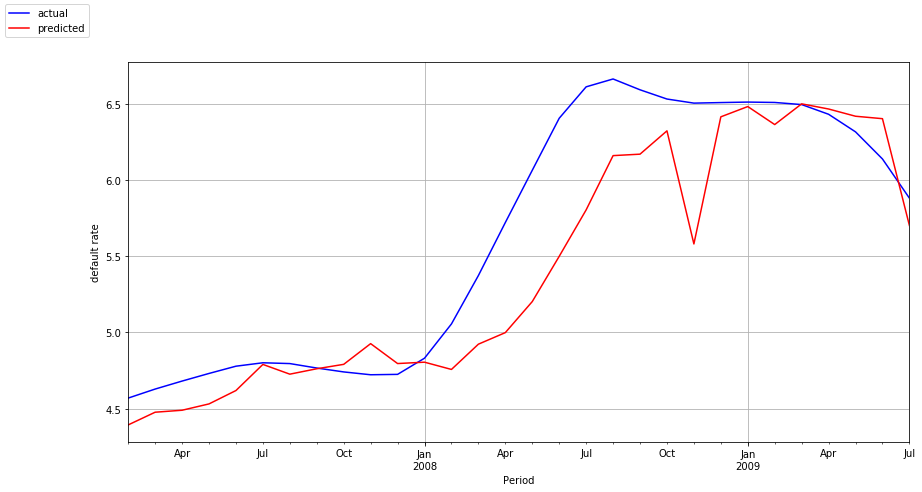

In [29]:
ind_series = pred_df.loc[:, 'actual'][-30:]
ind_name = 'actual'

dep_series = pred_df.loc[:, 'predicted'][-30:]
dep_name = 'predicted'

fig = plt.figure(figsize=(14,7))
plt.xlabel('Period')

ax1 = ind_series.plot(color='blue', grid=True, label=ind_name)
ax1.set_ylabel('default rate')
ax2 = dep_series.plot(color='red', grid=True, label=dep_name)
_ = fig.legend(loc='upper left')

There are two significant results in the data plotted above:
<ol>
    <li>When the economy deteriorates, the model might <i>lag</i> the true increase in the default rate. The predicted line aligns with the actual line approximately three months too late during the start of the great recession.</li>
    <li>The model still is an extremely good predictor that things are worsening. The recession officially began on December 2007, but was not officially declared for a full year, making December 2007 among the earliest times that one could know that the economy would dramatically falter. At that time, the model would have predicted an increase in the default rate of approximately 100bps in six months. The default rate actually rose closer to 175bps - while the model failed to accurately predict the magnitude of the increase, it did accurately predict that an increase would happen <i>before</i> it was known that the country was entering a recession.</li>
    </ol>